# Sávdetektálás megvalósítása egyenes útvonal esetén

Az algoritmus főbb lépései:

* Bemenetként RGB színes képek megadása.
* Kép átalakítása szürkeárnyalatossá.
* Gauss-szűrő alkalmazásával a képzaj csökkentése.
* Canny Edge Detector alkalmazása az élek felismerésére.
* Sávvonalak várható előfordulási területének körülhatárolása.
* Vonal koordináták megtalálása.
* Hough-transzformációval egyenesek illesztése.
* Koordináták illesztése a Canny képhez.
* Sikeres detektálás.



### Szükséges kiegészítő függvénykönyvtárak importálása

In [1]:
import numpy as np #matematikai háttér
import matplotlib.pyplot as plt #ábrára történő rajzoláshoz
import matplotlib.image as mpimg # kép betöltése, átméretezése
import cv2 #gépi látás funkciók
#a sorok eredménye legyen látható futtatás során ezen a felületen
%matplotlib inline  

### Tesztelni kívánt kép elérési útjának megadása

In [25]:
image = mpimg.imread(r'C:\Users\Eszti\Desktop\Python projects\Lane_test_kepek\m85.jpg')

### Kép megjelenítése a pontos méreteivel, továbbá alfa-keveréssel (4 csatornával) rendelkező kép 3 színcsatornássá tétele (opcionális)

Ez a kép: <class 'numpy.ndarray'> méretei: (713, 950, 3)


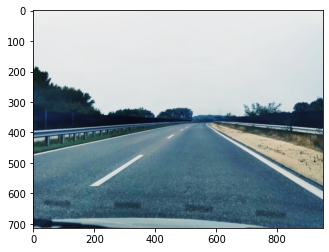

In [26]:
# színes kép megjelenítése a pontos méreteivel
print('Ez a kép:', type(image), 'méretei:', image.shape)
plt.imshow(image) 

#if len(image.shape) > 2 and image.shape[2] == 4:
    #kép átkonvertálása 
    #image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

#print('A kép adatai:', type(image), 'Kép méretei (szélesség, magasság) és a színcsatornák száma:', image.shape)
#plt.imshow(image)  

## Szín szerinti szűrés alkalmazása

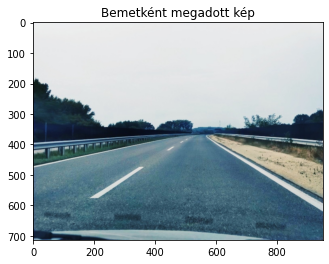

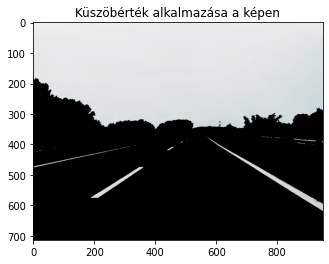

In [27]:
#másolat készítése a képről a magassága és szélessége alapján
magassag = image.shape[0]
szelesseg = image.shape[1]
szin_valasztas = np.copy(image)

#RGB színküszöb megadása, a fehér szín megtartása érdekében
piros_kuszob = 190
zold_kuszob = 190
kek_kuszob = 190

szin_kuszob = [piros_kuszob, zold_kuszob, kek_kuszob]

#pixelek elsötétítése a küszöbérték alatt
kuszobok = (image[:,:,0] < szin_kuszob[0]) \
            | (image[:,:,1] < szin_kuszob[1]) \
            | (image[:,:,2] < szin_kuszob[2])
szin_valasztas[kuszobok] = [0,0,0]

#kép megjeleítése
plt.imshow(image)
plt.title("Bemetként megadott kép")
plt.show()
plt.imshow(szin_valasztas)
plt.title("Küszöbérték alkalmazása a képen")
plt.show()

## Felismert vonal kiszínezése

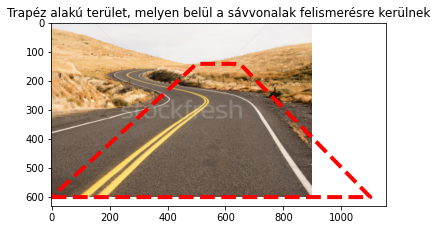

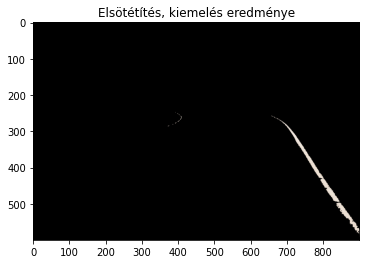

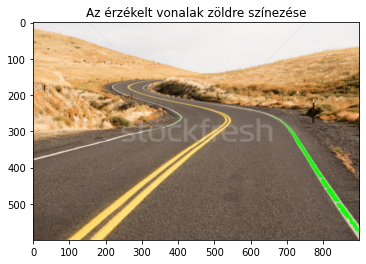

In [28]:
#másolat készítése a képről a magassága és szélessége alapján
image = mpimg.imread(r'C:\Users\Eszti\Desktop\Python projects\Lane_test_kepek\c.jpg')
magassag = image.shape[0]
szelesseg = image.shape[1]
szin_valasztas = np.copy(image)
vonalas_kep = np.copy(image)

#RGB színküszöb megadása, a fehér szín megtartása érdekében
piros_kuszob = 200
zold_kuszob = 200
kek_kuszob = 200

szin_kuszob = [piros_kuszob, zold_kuszob, kek_kuszob]

#megtartani kívánt alakzat a kép méretei alapján
bal_also = [0, 600]
bal_felso = [500, 140]
jobb_also = [1100, 600]
jobb_felso = [650, 140]

#elsőfokú lineáris polinom illesztése a geometria oldalaira
bal_polinom = np.polyfit((bal_also[0], bal_felso[0]), (bal_also[1], bal_felso[1]), 1)
felso_polinom = np.polyfit((bal_felso[0], jobb_felso[0]), (bal_felso[1], jobb_felso[1]), 1)
jobb_polinom = np.polyfit((jobb_felso[0], jobb_also[0]), (jobb_felso[1], jobb_also[1]), 1)
also_polinom = np.polyfit((bal_also[0], jobb_also[0]), (bal_also[1], jobb_also[1]), 1)

#pixelek elsötétítése a küszöbérték alatt
kuszobok = (image[:,:,0] < szin_kuszob[0]) \
            | (image[:,:,1] < szin_kuszob[1]) \
            | (image[:,:,2] < szin_kuszob[2])
szin_valasztas[kuszobok] = [0,0,0]

#trapéz alakzat a polinomok által
XX, YY = np.meshgrid(np.arange(0, szelesseg), np.arange(0, magassag))
trapez = (YY > (XX*bal_polinom [0] + bal_polinom [1])) & \
                    (YY > (XX*felso_polinom[0] + felso_polinom[1])) & \
                    (YY > (XX*jobb_polinom[0] + jobb_polinom[1])) & \
                    (YY < (XX*also_polinom[0] + also_polinom[1]))
                    
#alakzat színének megadása
szin_valasztas[kuszobok | ~trapez] = [0, 0, 0]
#vonalak zöld színnel történő megjelenítése
vonalas_kep[~kuszobok & trapez] = [9, 255, 0]

#kép megjelenítése a megadott beállításokkal
plt.imshow(image)
x = [bal_also[0], jobb_also[0], jobb_felso[0], bal_felso[0], bal_also[0]]
y = [bal_also[1], jobb_also[1], jobb_felso[1], bal_felso[1], bal_also[1]]
plt.plot(x, y, 'r--', lw=4)
plt.title("Trapéz alakú terület, melyen belül a sávvonalak felismerésre kerülnek")
plt.show()
plt.imshow(szin_valasztas)
plt.title("Elsötétítés, kiemelés eredménye")
plt.show()
plt.imshow(vonalas_kep)
plt.title("Az érzékelt vonalak zöldre színezése")
plt.show()

## Gauss-szűrő + Canny éldetektálás alkalmazása

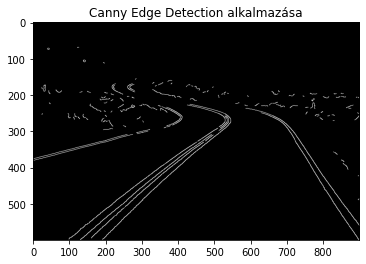

In [29]:
image = mpimg.imread(r'C:\Users\Eszti\Desktop\Python projects\Lane_test_kepek\c.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Gauss-szűrő alkalmazása
kernel_meret = 5 
elhomalyositott_szurke = cv2.GaussianBlur(gray,(kernel_meret, kernel_meret),0)

#Canny éldetektálás küszöbértékei
alacsony_kuszob = 180
magas_kuszob = 240
elek = cv2.Canny(elhomalyositott_szurke, alacsony_kuszob, magas_kuszob)

#Kép megjelenítése
plt.imshow(elek, cmap='Greys_r')
plt.title("Canny Edge Detection alkalmazása")
plt.show()

## Trapéz alakú terület definiálása, Hough-transzformáció alkalmazása

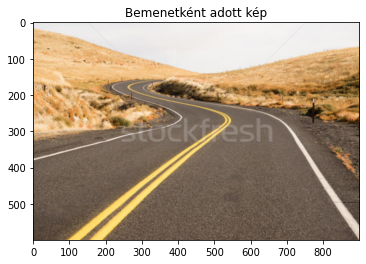

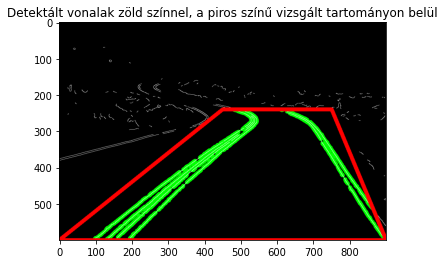

In [30]:
image = mpimg.imread(r'C:\Users\Eszti\Desktop\Python projects\Lane_test_kepek\c.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Gauss-szűrő alkalmazása
kernel_meret = 5 
elhomalyositott_szurke = cv2.GaussianBlur(gray,(kernel_meret, kernel_meret),0)

#Canny éldetektálás küszöbértékei
alacsony_kuszob = 180
magas_kuszob = 240
elek = cv2.Canny(elhomalyositott_szurke, alacsony_kuszob, magas_kuszob)


#maszk definiálása kezdeti nulla értékekkel
maszk = np.zeros_like(elek)   
maszk_szine = 255    

#határoló alakzat (trapéz) definiálása a 4 sarokponjával
alakzat = image.shape
csucsok = np.array([[(0,alakzat[0]),(450, 240), (750, 240), (alakzat[1],alakzat[0])]], dtype=np.int32)
cv2.fillPoly(maszk, csucsok, maszk_szine)
maszk_elek = cv2.bitwise_and(elek, maszk)


#Hough-transzformáció paramétereinek megadása
ro = 1 # Hough térbeli rácsok távolságának felbontása
teta = np.pi/180 # Hough-rács szögfelbontása radiánban
kuszob = 2     # Houg cellán belüli minimális metszéspont
min_vonal_hossz = 4 #vonalakat alkotó képpontok minimális száma
max_vonal_koz = 5  #maximális távolság pixelben a csatlakozó vonalszakaszok között
vonalas_kep = np.copy(image)*0 #kép létrehozása rajzoláshoz

#Hough-transzformáció futtatása egy éldetektált képen
vonalak = cv2.HoughLinesP(maszk_elek, ro, teta, kuszob, np.array([]),
                            min_vonal_hossz, max_vonal_koz)

    
#vonalak rajzolása a képre, iterációt követően
for line in vonalak:
    for x1,y1,x2,y2 in line:
        cv2.line(vonalas_kep,(x1,y1),(x2,y2),(0,255,0),10)

#Rajzolt kép egyesítése egy színes bináris képen
szines_vonalak = np.dstack((elek, elek, elek)) 

#Hough-transzformáció eredménye
vonal_csucsok = cv2.addWeighted(szines_vonalak, 0.8, vonalas_kep, 1, 0)
vonal_csucsok = cv2.polylines(vonal_csucsok,csucsok, True, (255,0,0), 10)
plt.imshow(image)
plt.title("Bemenetként adott kép")
plt.show()
plt.imshow(vonal_csucsok)
plt.title("Detektált vonalak zöld színnel, a piros színű vizsgált tartományon belül")
plt.show()

# Algoritmus összefoglalva

In [86]:
import math

#szürkeárnyalatos kép definiálása
def grayscale(img):
    #színes kép szürkeárnyalatossá konvertálása
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#Canny (éldetektáló) definiálása küszöbértékek alkalmazásával    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

#Gauss-szűrő definiálása kernel (szűrő) méret alkalmazásával
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#Sávvonalak várható előfordulási területének körülhatárolása
def region_of_interest(img, vertices):
    #vizsgálat céljának megfelelő terület megadása
    #2D-s üres tömb létrehozása sorok és oszlopok feltöltöséhez szürkeárnyalatos kép esetén 
    #(a távolság és szög változók tárolására (későbbi egyenes meghatározáshoz))
    #üres tömb ugyanolyan széles, magas, mint az eredeti kép
    mask = np.zeros_like(img)   
    
    #régión kívüli területek figyelmenhagyása
    if len(img.shape) > 2: #kép alakjának lekérése, sorok-oszlopok-csatornák száma (len- lista elemszámainak visszaadása)
        channel_count = img.shape[2]  #csatornaszám változóban a képadatok magasság és szélesség adatok tárolása
        ignore_mask_color = (255,) * channel_count #figyelmenkívül hagyott szín
    else:
        ignore_mask_color = 255
        
    #geometrián belül a színek meghagyása      
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #amennyiben a kép pixelei nem nullál visszaadja a képet
    masked_image = cv2.bitwise_and(img, mask) #bitenkénti operátorok alkalmazása a kép vizsgálaton kívüli részének elhagyásához
    #visszatérési érték egy tömb, mely az eredeti kép egyesítéséből adódik
    return masked_image

#Vonalak rajzolásának definiálása, szín és vastagság megadásával 
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

#Lejtésirány meghatározása 
def slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # baloldali vonalak /
    right_lines = [] # jobboldali vonalak \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Függőleges vonal illesztése
            else:
                m = (y2 - y1) / (x2 - x1) #egyenes meredeksége
                c = y1 - m * x1 #egyenes egyenlete a tengelymetszetet kifejezve

                if m < 0:
                    left_lines.append((m,c)) #ha a meredség kisebb nullánál, baloldali vonalhoz történő besorolás
                elif m >= 0:
                    right_lines.append((m,c)) #ha a meredség nagyobb vagy egyenlő, mint nulla, jobboldali vonalhoz való besorolás

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #print(left_line, right_line)
    
#Lejtésirány meghatározához for ciklus  
    for slope, intercept in [left_line, right_line]:

        #kép teljes magasságának megadása
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #azon magasság megadása ameddig a felismert sáv kitöltésre kerül(magasságmérés bal felsősaroktól lefele történik)
        #ezen érték meghatározása videónként eltérő
        y2= int(rows*0.65) #int(0.6*y1)

        #egyenes egyenletéből: y=mx +c az x kifjeezése: x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    #poligon csúcsainak megadása
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)

    cv2.polylines(img,np.array([poly_vertices],'int32'), True, (0,0,255), 10)
    print(poly_vertices)
    cv2.polylines(img,np.array([poly_vertices],'int32'), True, (0,0,255), 10)
    print(poly_vertices)


#Hough-transzformáció paramétereinek megadása    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Canny transzformáció eredménye a bemeneti (img) kép
        
    Hough-vonalakkal ellátott eredmény képet ad kimentként.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    line_img = slope_lines(line_img,lines) #sáv kitöltése
    return line_img

#súlyozott kép definiálása
def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    """
    Hough-transzformáció eredményeként kapott kép megadása bementként (img)
    
    `initial_img` = feldolgozás előtti eredeti bemeneti kép
    
    Eredmény kép számítása:
    
    initial_img * α + img * β + γ
    Fontos, hogy a két kép azonos méretű legyen!
    """
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    #lines_edges = cv2.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10) #trapéz láthatóvá tétele
    return lines_edges

#Trapéz alakú geometria csúcspontjainak paraméterezése (egyes videók esetén elétrő paraméterek szükségesek)
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.65]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.65] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

## Sáv detektálása

In [87]:
#Sávkereső algoritmus definiálása
def lane_finding_pipeline(image):
    
    
    gray_img = grayscale(image)
    
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
   
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
   
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    
    return output

## Detektálás eredménye képfájlokra

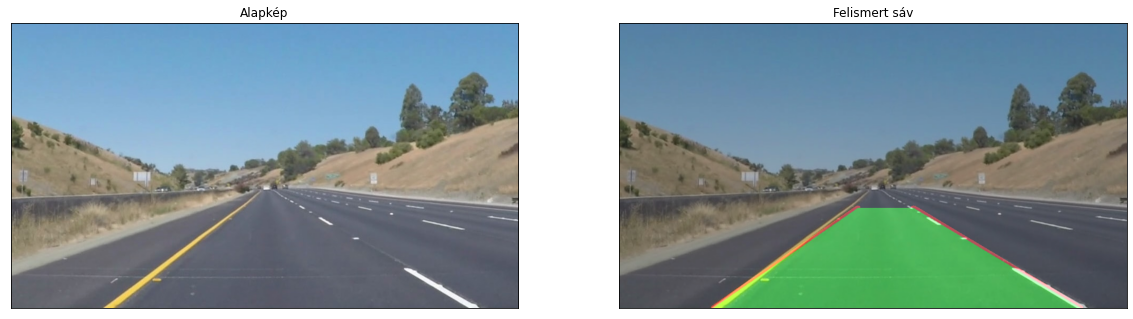

In [88]:
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(r'C:\Users\Eszti\Desktop\Python projects\Lane_test_kepek/whiteCarLaneSwitch.jpg')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Alapkép")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(lane_finding_pipeline(image))
    ax.set_title("Felismert sáv")
    plt.show()